# Part A Logistic Regression vs. Bayesian Classifier

I. load data

In [1]:
read_data <- function(fname) 
{
   data <- read.csv(file=fname,head=TRUE,sep=",")
   return (data)
}
train_data = read_data('./Task1A_train.csv')
test_data = read_data('./Task1A_test.csv')
c0 <- 1
c1 <- -1

In [2]:
train.len <- 5
train.index <- 1:train.len
train.data <- train_data[train.index, c('x1', 'x2')]
train.label <- train_data[train.index, 'y']
test.data <- test_data[c('x1', 'x2')]
test.label <- test_data['y']

II. BC and LR model define

In [4]:
library(mvtnorm)
library(reshape2)

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"

## Bayesian Classifier 

In [5]:
bay_class <- function(train.len)
{
    train.index <- 1:train.len
    train.data <- train_data[train.index, c('x1', 'x2')]
    train.label <- train_data[train.index, 'y']
    test.data <- test_data[,c('x1', 'x2')]
    test.label <- test_data[,'y']

    p0.hat <- sum(train.label==c0)/nrow(train.data)
    p1.hat <- sum(train.label==c1)/nrow(train.data)

    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 


    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma0.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma1.hat)
    posterior_train <- posterior0 + posterior1
    x <- posterior0 / posterior_train
    train_loss = sum(ifelse(train.label==c0, 1-x, x)) / length(train.label)
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)

    posterior0_test <- p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma0.hat)
    posterior1_test <- p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma1.hat)
    posterior_test <- posterior0_test + posterior1_test
    x <- posterior0_test / posterior_test
    test_loss = sum(ifelse(test.label==c0, 1-x, x)) / length(test.label)
    test.predict <- ifelse(posterior0_test > posterior1_test, c0, c1)

    return (c(train_loss, test_loss))
    
}
x <- bay_class(10)

In [6]:
train_cost_bc <- c()
test_cost_bc <- c()
x <- seq(5, length(train_data$y),5)
for(i in x)
{
    cost_ = bay_class(i)
    train_cost_bc = c(train_cost_bc, cost_[1])
    test_cost_bc = c(test_cost_bc, cost_[2])
}

## Linear Regression

In [7]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

In [8]:
# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [9]:
LR_class <- function(train.len)
{
    train.index <- 1:train.len
    train.data <- train_data[train.index, c('x1', 'x2')]
    train.label <- train_data[train.index, 'y']
    test.data <- test_data[c('x1', 'x2')]
    test.label <- test_data['y']
    # Initializations
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label== c0,0,1) # rename just for conviniance

    X_test <- as.matrix(test.data) # rename just for conviniance
    T_test <- ifelse(test.label== c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    # set.seed(1)
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)

    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
        
        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]
        # print(X)
        
        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)
            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
            
            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0) / length(T)
            
            # update the counter:
            tau <- tau + 1
            
            # decrease learning rate:
            eta = eta * 0.999
        }
    }

    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    # print(W)
    # print(costs)
    cost_test <- cost(W[tau,],X_test,T_test, c0) / length(T_test)
    # cat('\nThe final cost are:', costs[tau,'cost'], 'The final test cost are:', cost_test)
    return (c(costs[tau,'cost'], cost_test))
}

In [10]:
train_cost_lr <- c()
test_cost_lr <- c()
x <- seq(5, length(train_data$y),5)
for(i in x)
{
    cost_ = LR_class(i)
    train_cost_lr = c(train_cost_lr, cost_[1])
    test_cost_lr = c(test_cost_lr, cost_[2])
}

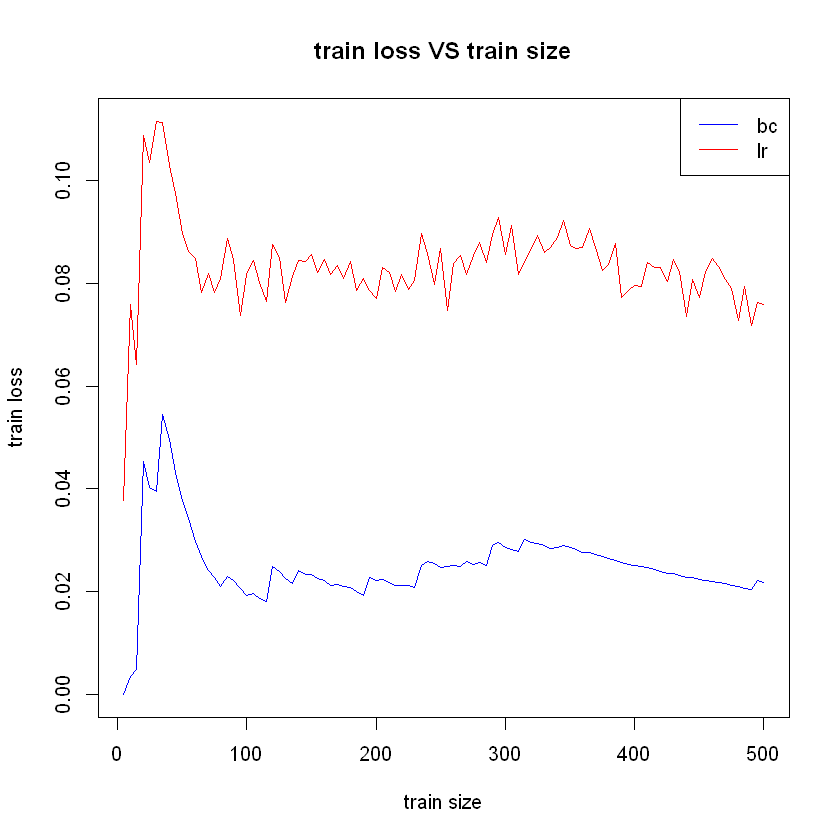

In [11]:
max_ = max(train_cost_bc, train_cost_lr)
min_ = min(train_cost_bc, train_cost_lr)
plot(x, train_cost_bc, type='l', xlab = 'train size', ylab = 'train loss', main = 'train loss VS train size', col = 'blue', ylim = c(min_, max_))
lines(x, train_cost_lr, col = 'red')
legend('topright',c("bc","lr"),col=c('blue','red'),lty=c(1,1))


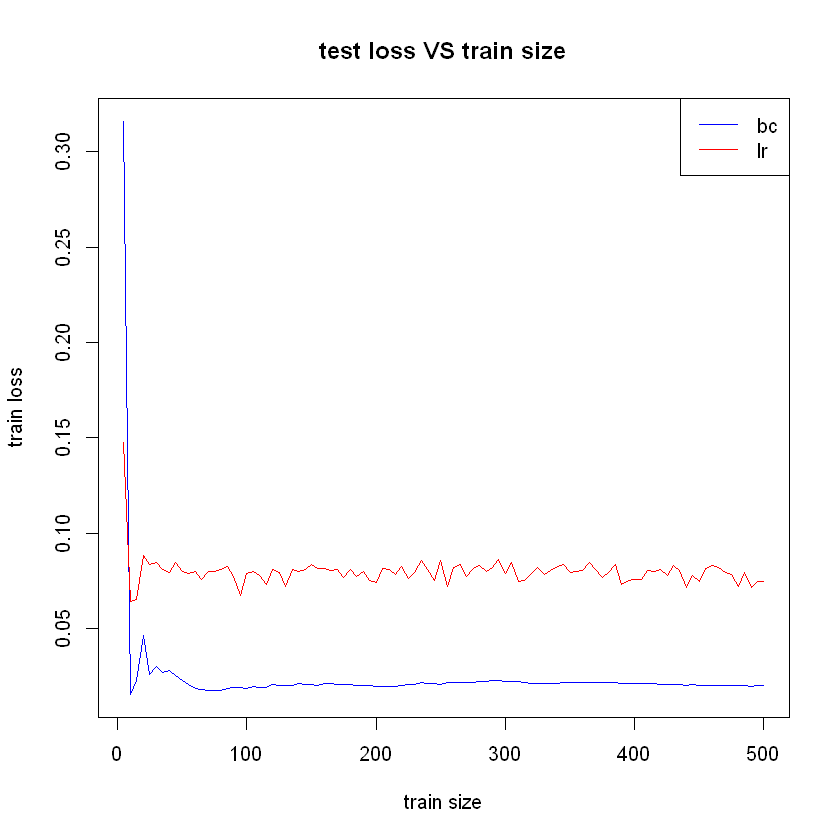

In [12]:
max_ = max(test_cost_bc, test_cost_lr)
min_ = min(test_cost_bc, test_cost_lr)
plot(x, test_cost_bc, type='l', xlab = 'train size', ylab = 'train loss', main = 'test loss VS train size', col = 'blue', ylim = c(min_, max_))
lines(x, test_cost_lr, col = 'red')
legend('topright',c("bc","lr"),col=c('blue','red'),lty=c(1,1))

III

(a) With the increase of the number of training data points, the test loss decrease. With the increase of the number of training data points. the train loss will increase initally and then decrease.

(b) When the training set is small, logistic regression may be the most suitable classifier and when the training set is big, bayes classifier is the most suitable classifier.

(c) When training set is small, the model can learn the training data feactures much easier, so the training loss is small. And when training set gets larger, the data may has several outliers and will increase the model peorformance. But with the icrease of the data set, the average loss will decrease to a stable level. The logistic regression is simple and can slove simple classified problem, so when the train data size is large, it is easy to underfit, so when the training set is big, bayes classifier is the most suitable classifier and when the training set is small, the mu and sigma calculated is far from the total mu and sigma, so it is difficult for bayes classifier to make correct prediction. So logistic regression is better.
